In [1]:
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the dataframe
df = pd.read_excel('Portland Sandstone play - Weald Basin - well summary data.xlsx')

# data preparation
df[['easting', 'northing']] = df[['OSGB easting', 'OSGB northing']].applymap(lambda x: int(str(x)[:-2]))
df['seal'] = df['seal presence and effectiveness (Purbeck Beds)']
df['X'] = (df['easting'] - min(df['easting'])) / 1000    #scaling, to avoid big numbers and minimize calculation error
df['Z'] = (df['northing'] - min(df['northing'])) / 1000  #scaling, to avoid big numbers and minimize calculation error
df['overall'] = df[['seal', 'reservoir', 'depth']].min(axis=1) 

labels = df['Unnamed: 1']

In [3]:
#check the dataframe
df.head()

,Well name,Unnamed: 1,OSGB easting,OSGB northing,top Portland Beds,top Kimmeridge Clay,reservoir,depth,seal presence and effectiveness (Purbeck Beds),easting,northing,seal,X,Z,overall
0,Albury 1,ALB,506182 E,147192 N,2553',2647',3.0,2.0,2.0,506182,147192,2.0,69.584,49.158,2.0
1,Ashington 1,ASH,512750 E,118230 N,1936',2027',3.0,2.0,2.0,512750,118230,2.0,76.152,20.196,2.0
2,Ashour 1,ASR,556400 E,144240 N,919',1027',3.0,1.0,2.0,556400,144240,2.0,119.802,46.206,1.0
3,Avington 1,AV,453692 E,129523 N,2286',2545',3.0,3.0,2.0,453692,129523,2.0,17.094,31.489,2.0
4,Balcombe 1,BAL,531031 E,129242 N,1414',1619',2.0,1.0,3.0,531031,129242,3.0,94.433,31.208,1.0


In [4]:
# create our own colormap
colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0)]  # Red -> Yellow -> Green
cmap_name = 'my_cmap'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=1000)

In [5]:
def plotmap(params = ['seal', 'reservoir', 'depth', 'overall']):
    '''
    param : list of string (options: 'seal', 'reservoir', 'depth', 'overall')
            default : all parameters
    '''
    if isinstance(params, str):
        params = [params]
    
    n = len(params)
    
    # creating our grid
    lons=np.array(df['X'])
    lats=np.array(df['Z'])
    grid_space = 1
    grid_lon = np.arange(np.amin(lons), np.amax(lons)+1, grid_space)
    grid_lat = np.arange(np.amin(lats), np.amax(lats)+1, grid_space)
    boundary = [grid_lon[0], grid_lon[-1], grid_lat[0], grid_lat[-1]]
    
    if n == 1:
        # defining figure and kriging
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6,2])
        data=np.array(df[params[0]])
        OK = OrdinaryKriging(lons, lats, data, variogram_model='exponential', enable_plotting=False, nlags=20)
        z1, ss1 = OK.execute('grid', grid_lon, grid_lat)
        
        # plotting risk value
        im = ax.imshow(z1, extent=boundary, cmap=cmap, vmin=1, vmax=3)
        ax.plot(lons, lats, 'k.')
        for i, txt in enumerate(labels):
            ax.annotate(txt, (lons[i], lats[i]), fontsize=7)
        ax.set_title(params[0].capitalize() + ' Risk Map')
        ax.axis('off')
        fig.colorbar(im, ticks=[1,2,3], ax=ax);
    
    else:
        # defining figure
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12,4])
        
        for ax, param in zip(axes.flat, params):
            # kriging
            data=np.array(df[param])
            OK = OrdinaryKriging(lons, lats, data, variogram_model='exponential', enable_plotting=False, nlags=20)
            z1, ss1 = OK.execute('grid', grid_lon, grid_lat)

            # plotting risk value
            im = ax.imshow(z1, extent=boundary, cmap=cmap, vmin=1, vmax=3)
            ax.plot(lons, lats, 'k.')
            for i, txt in enumerate(labels):
                ax.annotate(txt, (lons[i], lats[i]), fontsize=7)
            ax.set_title(param.capitalize() + ' Risk Map')
            ax.axis('off')
            
        # hiding unnecesary axes
        if n < 4:
            axes[1, 1].axis('off')
            if n < 3:
                axes[1, 0].axis('off')
            
        fig.colorbar(im, ticks=[1,2,3], ax=axes.ravel().tolist());
    
    return None

Now we can create a single map, or subplots of maps for example:

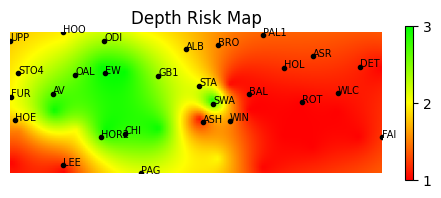

In [6]:
plotmap('depth')

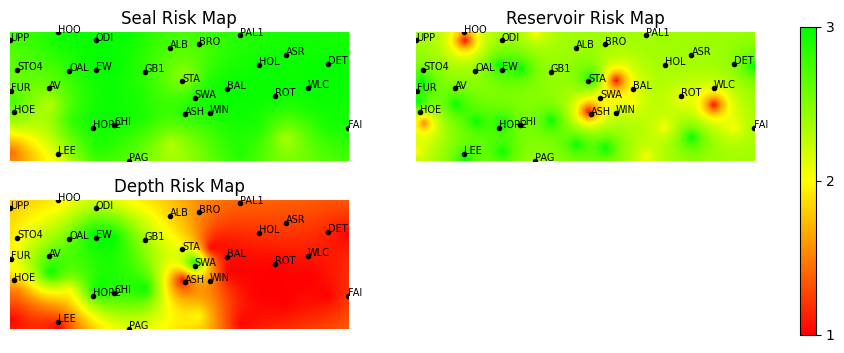

In [7]:
plotmap(['seal', 'reservoir', 'depth'])

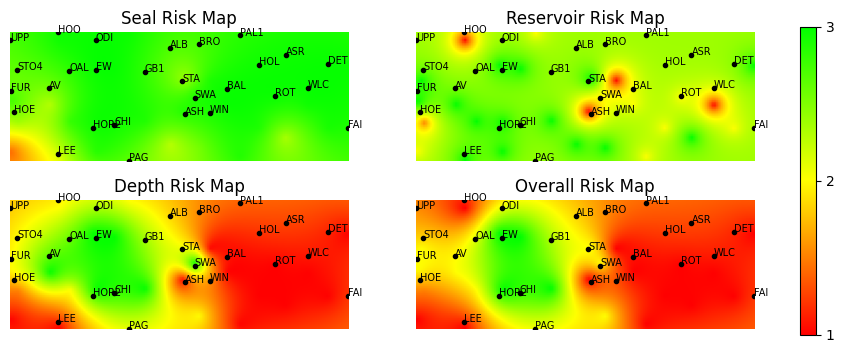

In [8]:
plotmap(['seal', 'reservoir', 'depth', 'overall'])